In [1]:
## Import Libraries
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

from skimage import exposure
from skimage import filters

import cv2
import trackpy as tp
import pandas as pd

import pims
import libtiff
import tifftools

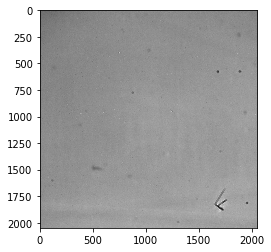

In [2]:
## Verify that the images that we are looking at are real

fname = '/Volumes/EliseWork/20210210_Data/20210210_20210209_01_1_21G_01-out1.tif'
frames = pims.TiffStack_libtiff(fname)

#frames[0] #Checks that it exists
#frames[700].frame_no
#frame[0].metadata #Get the metadata

plt.imshow(frames[1])


In [3]:
## Merge all the tiff files from the same sample
# The microscope creates multiple .tif files for the same video sample 
# for trajectory analysis they need to be stictched together

## This takes a significant Amount of time (the files are big)


foldername = '/Volumes/EliseWork/20210210_Data/'


metadata = pd.read_csv(foldername + 'metadata.csv')

for m in range(3,len(metadata)):
    shortfname = metadata['FileName'][m]
    input = tifftools.read_tiff(foldername + shortfname + '.tif')
    j=1
    for i in range(1, metadata['FileNumbers'][m]):
        j=j+1
        input2 = tifftools.read_tiff(foldername + shortfname + '-file00' +  str(j) + '.tif')
        # Add all the files 
        input['ifds'].extend(input2['ifds'])
    tifftools.write_tiff(input, foldername + shortfname + '-out1.tif')
    

In [37]:
## Function to pre-process images
@pims.pipeline
def pre_process(frame):
    fr = filters.gaussian(frame, sigma=1) #Removes noise
    p2, p98 = np.percentile(fr, (2, 98))
    fr = exposure.rescale_intensity(fr, in_range=(p2, p98)) #Enhances the contrast of the image
    return fr

In [38]:
## Import the data and analyze everything

outfoldername = '/Volumes/EliseWork/20210625Motility/out_mindist20/'
foldername = '/Volumes/EliseWork/20210625Motility/'


metadata = pd.read_csv(foldername + 'metadata.csv')

for m in range(0,len(metadata)):
    shortfname = metadata['FileName'][m]
    fname = foldername + shortfname + '-out.tif'
    frames = pims.TiffStack_libtiff(fname)
    pframes = pre_process(frames) # Pre-process the frames
    f = tp.batch(pframes, 11, minmass = 1, invert=True,percentile=98.5) #Locate features
    f.to_csv(outfoldername + shortfname + '-features.csv')
    t = tp.link_df(f, 50) #Create trajectories
    t1 = tp.filter_stubs(t, 50) #Filter out spurious trajectories
    t1.to_csv(outfoldername + shortfname + '-traj.csv')
    d = tp.compute_drift(t1) #Calculate drift
    tm = tp.subtract_drift(t1, d) #Remove drift
    im = tp.imsd(tm, 6.5/20, 40)  #Calculate the Individual Mean Square Displacement of each trajectory
    im.to_csv(outfoldername + shortfname + '-imsd.csv')
    em = tp.emsd(tm, 6.5/20, 40)  #Calculate the Ensemble Mean Square Displacement of each trajectory
    em.to_csv(outfoldername + shortfname + '-emsd.csv')
    
# Further Analysis was performed in R 

Frame 2019: 232 features


In [42]:
## Import the data and analyze everything for different distances 

outfoldername = '/Volumes/EliseWork/20210625Motility/out_mindist20/'
foldername = '/Volumes/EliseWork/20210625Motility/out_mindist20/'


#metadata = pd.read_csv('/Volumes/EliseWork/20210210_Data/metadata.csv')

#for m in range(0,len(metadata)):
for spur_dist in range(10,50,5):
    shortfname = "Exp_FR30_E3ms" #For one particular selected file - where features have already been detected
    fname = foldername + shortfname + '-features.csv'
    f = pd.read_csv(fname)
    t = tp.link_df(f, 20) #Create trajectories
    t1 = tp.filter_stubs(t, spur_dist) #Filter out spurious trajectories
    t1.to_csv(outfoldername + shortfname + "_" + str(spur_dist) + '-traj.csv')
    d = tp.compute_drift(t1) #Calculate drift
    tm = tp.subtract_drift(t1, d) #Remove drift
    im = tp.imsd(tm, 6.5/20, 30)  
    im.to_csv(outfoldername + shortfname + "_" + str(spur_dist) +'-imsd.csv')
    em = tp.emsd(tm, 6.5/20, 30)  
    em.to_csv(outfoldername + shortfname + "_" + str(spur_dist) +'-emsd.csv')

Frame 999: 276 trajectories present.
